## Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from typing import List
from plot import get_n_classes_2d_toy_dataset, plot_2d_toy_dataset, plot_losses_and_accuracies, train_model_for_toy_dataset
from plot import plot_boundries_per_class, plot_boundries, plot_ignorance_uncertainity_confusion

from loss import custom_loss, calculate_only_belief_uncertainity_ignorance_confusion

# and set the seed for reproducibility
random_seed = 42
random.seed(random_seed)

## Create the MLP model for classifying the 2D points

In [2]:
class MLP(nn.Module):
    def __init__(self,
                 last_layer_activation: nn.Module,
                 input_dim: int,
                 hidden_dims: List[int],
                 output_dims: int,
                 activation: nn.Module = nn.LeakyReLU(0.2)):
        super(MLP, self).__init__()

        self.last_layer_activation = last_layer_activation

        counter = 0

        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            current_fc_layer = nn.Linear(prev_dim, hidden_dim)
            setattr(self, f'fc_{counter}', current_fc_layer)
            counter += 1
            prev_dim = hidden_dim
        
        last_fc_layer = nn.Linear(prev_dim, output_dims)

        setattr(self, f'fc_{counter}', last_fc_layer)

        self.activation = activation

        self.layer_count = counter + 1
    
    def forward(self, x):
        
        for i in range(self.layer_count):
            x = getattr(self, f'fc_{i}')(x)
            if i != self.layer_count - 1:
                x = self.activation(x)
            else:
                x = self.last_layer_activation(x)
        return x

## Generate the 2D toy dataset

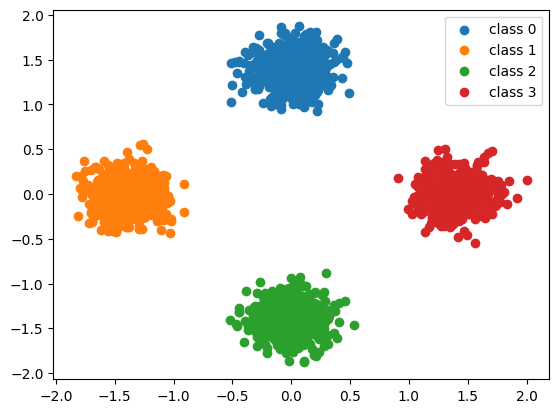

In [3]:
# Generate some data
n_classes = 4
n_samples_per_class = 500
std = 1
distance = 9
shuffle = True

# set the seed again
random.seed(random_seed)

# Generate the data
X, y = get_n_classes_2d_toy_dataset(n_classes=n_classes,
                                    n_samples_per_class=n_samples_per_class,
                                    std=std,
                                    distance=distance,
                                    random_seed=random_seed,
                                    shuffle=shuffle)

# Normalize the data
X = (X - X.mean(axis=0)) / X.std(axis=0)

plot_2d_toy_dataset(X, y, n_classes)

## Get the data ready for training

In [4]:
# Split the data into training and test validation
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# convert labels to one-hot encoding
y_train = np.eye(n_classes)[y_train]
y_validation = np.eye(n_classes)[y_validation]

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_validation = torch.tensor(X_validation, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.float32)

# print the first 10 data
print(X_train[:10])
print(y_train[:10])

tensor([[-0.1943,  1.5300],
        [ 1.3909, -0.0239],
        [-0.1448, -1.6218],
        [ 1.4131,  0.0406],
        [ 1.2287,  0.0104],
        [-1.5069, -0.0470],
        [ 1.0808, -0.1696],
        [-0.2465,  1.3752],
        [-0.0835,  1.3531],
        [ 0.0392,  1.2240]])
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])


## Define 2 exact MLP models

In [5]:
# create the MLP which will be trained with the classic loss
MLP_classic = MLP(input_dim=2,
                  hidden_dims=[16, 32, 16],
                  output_dims=n_classes,
                  activation=nn.Tanh(),
                  last_layer_activation=nn.Sigmoid())


# print the MLP
print("MLP with classic loss:")
print(MLP_classic)

MLP with classic loss:
MLP(
  (last_layer_activation): Sigmoid()
  (fc_0): Linear(in_features=2, out_features=16, bias=True)
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=16, bias=True)
  (fc_3): Linear(in_features=16, out_features=4, bias=True)
  (activation): Tanh()
)


## Train the classic model

In [6]:
# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the loss function for our loss
classic_loss_object = nn.CrossEntropyLoss()

# create the optimizer for the classic loss (SGD with momentum)
optimizer_classic = optim.SGD(MLP_classic.parameters(), lr=0.01, momentum=0.9)


train_loss_classic_loss, train_accuracy_classic_loss, validation_loss_classic_loss, validation_accuracy_classic_loss = train_model_for_toy_dataset(
    model=MLP_classic,
    optimizer=optimizer_classic,
    loss_fn=classic_loss_object,
    device=device,
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation,
    n_epochs=1000,
    verbose=True,
    verbose_every=500
)

Epoch 499:
Train loss: 0.8754916787147522, Train accuracy: 1.0
Validation loss: 0.8788517713546753, Validation accuracy: 1.0

Epoch 999:
Train loss: 0.7817054390907288, Train accuracy: 1.0
Validation loss: 0.7817713022232056, Validation accuracy: 1.0



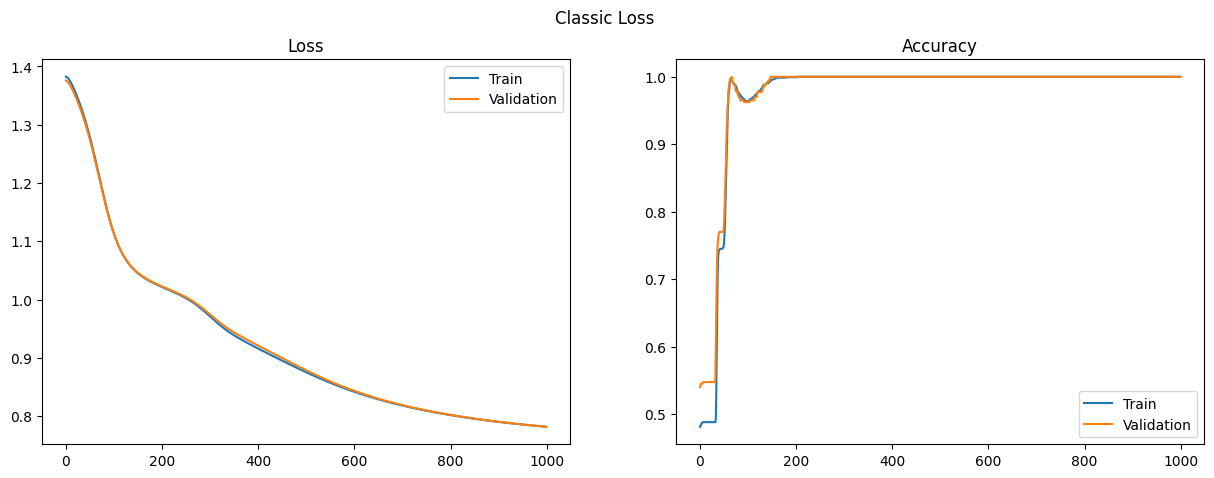

In [7]:
# plot the losses and accuracies
plot_losses_and_accuracies(train_loss_classic_loss,
                           train_accuracy_classic_loss, 
                           validation_loss_classic_loss,
                           validation_accuracy_classic_loss,
                           title="Classic Loss")

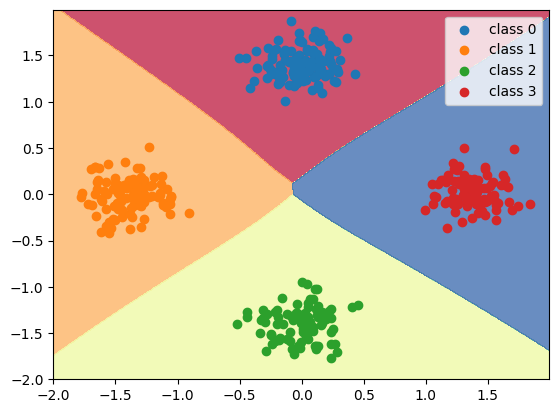

In [8]:
# plot the decision boundries
plot_boundries(MLP_classic,
    device = "cpu",
    X = X_validation,
    y = y_validation,
    n_classes=n_classes,
    plot_step=0.005,
    x_min=-2,
    x_max=2,
    y_min=-2,
    y_max=2
)

## Train the model with custom loss (the papers uncertainity loss)

In [9]:
# create the MLP which will be trained with the losses in the paper
MLP_with_our_loss = MLP(input_dim=2,
                        hidden_dims=[16, 32, 16],
                        output_dims=n_classes,
                        activation=nn.Tanh(),
                        last_layer_activation=nn.Sigmoid())

# print the MLP
print("\nMLP with our loss:")
print(MLP_with_our_loss)


MLP with our loss:
MLP(
  (last_layer_activation): Sigmoid()
  (fc_0): Linear(in_features=2, out_features=16, bias=True)
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=16, bias=True)
  (fc_3): Linear(in_features=16, out_features=4, bias=True)
  (activation): Tanh()
)


In [10]:
# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

our_method_epochs = 1000

# create the loss function for our loss
our_loss_object = custom_loss(
    max_epochs=our_method_epochs,
    max_lambda_kl=0.05,
    annealing_last_value=0.0,
    n_classes=n_classes,
    lambda_reg=1.0
)

# create the optimizer for the our loss (SGD with momentum)
optimizer_our_loss = optim.SGD(MLP_with_our_loss.parameters(), lr=0.004, momentum=0.9)


train_loss_our_loss, train_accuracy_our_loss, validation_loss_our_loss, validation_accuracy_our_loss = train_model_for_toy_dataset(
    model=MLP_with_our_loss,
    optimizer=optimizer_our_loss,
    loss_fn=our_loss_object,
    device=device,
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation,
    n_epochs=our_method_epochs,
    verbose=True,
    verbose_every=5000
)

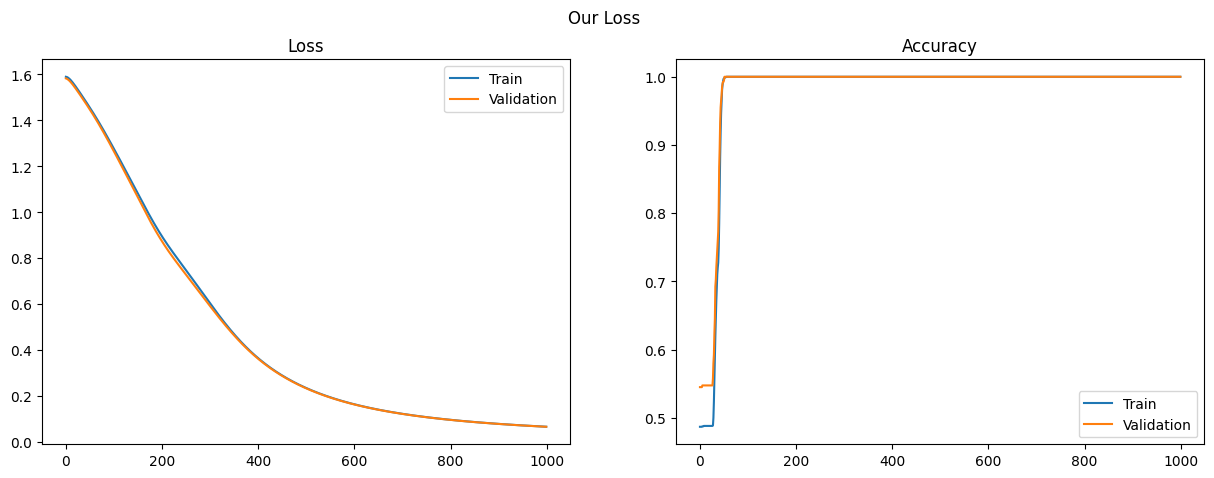

In [11]:
# plot the losses and accuracies
plot_losses_and_accuracies(
    train_loss_our_loss,
    train_accuracy_our_loss,
    validation_loss_our_loss,
    validation_accuracy_our_loss,
    title="Our Loss",
)

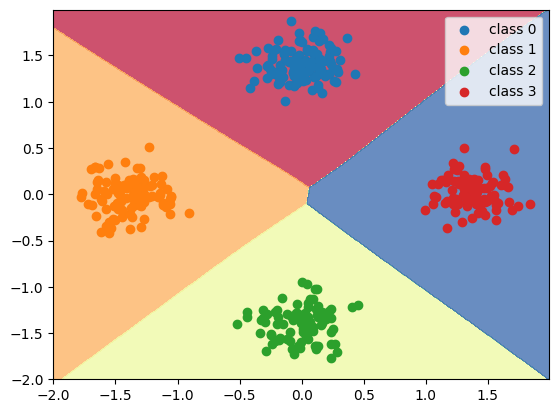

In [12]:
# plot the boundries
plot_boundries(
    model=MLP_with_our_loss,
    device="cpu",
    X=X_validation,
    y=y_validation,
    n_classes=n_classes,
    plot_step=0.005,
    x_min=-2,
    x_max=2,
    y_min=-2,
    y_max=2
)

## Visualize the confusion and ignorance values in boundries

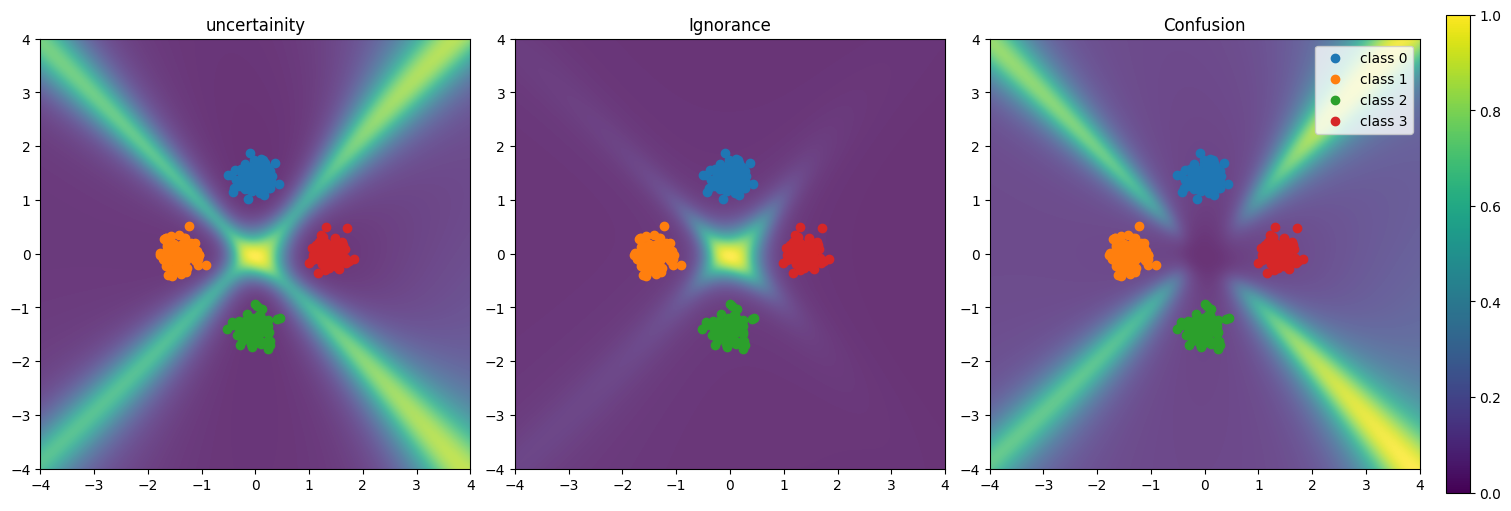

In [13]:
# plot the ignorance, uncertainity and confusion
plot_ignorance_uncertainity_confusion(
    model=MLP_with_our_loss,
    device="cpu",
    X=X_validation,
    y=y_validation,
    n_classes=n_classes,
    plot_step=0.005,
    x_min=-4,
    x_max=4,
    y_min=-4,
    y_max=4
)

In [14]:
# input a point and measure the beliefs, uncertainity, ignorance and confusion
x_sample = torch.tensor([[2.0, 2.0]], dtype=torch.float32)

y_pred_sample = MLP_with_our_loss(x_sample)

with torch.no_grad():
    beliefs, uncertainity, ignorance, confusion = calculate_only_belief_uncertainity_ignorance_confusion(y_pred_sample)


print(f"for the point ({x_sample[0,0]},{x_sample[0,1]}):")
print(f"plausibilities: {[float(x) for x in y_pred_sample.detach().numpy()[0]]}")
print(f"Beliefs: {[float(x) for x in beliefs.numpy()[0]]}")
print(f"Uncertainity: {uncertainity}")
print(f"Ignorance: {ignorance}")
print(f"Confusion: {confusion}")

print((1-y_pred_sample).prod())

for the point (2.0,2.0):
plausibilities: [0.8244442343711853, 0.0016619033413007855, 0.0011335911694914103, 0.8382753729820251]
Beliefs: [0.1329604536294937, 4.713075759354979e-05, 3.2131083571584895e-05, 0.1467529535293579]
Uncertainity: tensor([0.7202])
Ignorance: tensor([0.0283])
Confusion: tensor([0.6919])
tensor(0.0283, grad_fn=<ProdBackward0>)
